### Heat Map for Predictions
#### This script replicates the heat map procedure from James Trotman @ https://www.kaggle.com/jtrotman/visualise-stage-1-submission-as-heatmaps-mens

#### Once we create our predictions using RF, GBM, Bayesian Networks, and SVM, we will use the heat map to present the predictions

#### We will add an updated heat map with actuals for the games actually played, with "White" being games that were not played, "Red" being games we predicted correctly, and "Blue" being games we predicted incorrectly

##### Load Packages

In [10]:
import numpy as np
import pandas as pd
import os, re, sys
from scipy.special import logit, expit
from itertools import combinations
import matplotlib.pyplot as plt

##### Set backend of matplotlib to inline (magic function)

In [11]:
%matplotlib inline

##### Import Data

In [16]:
os.chdir('C:\\Users\\Jared\\OneDrive\\Documents\\Kaggle\\March Madness 2018\\Data')
seeds = pd.read_csv('NCAATourneySeeds.csv')
teams = pd.read_csv('Teams.csv')
# Create dictionary from 'Teams.csv' to present team names
id2team = dict(teams[['TeamID','TeamName']].values)

##### Functions

In [13]:
def do_plot_heatmap(probs, team_labels, filename):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    # try different colormaps: http://matplotlib.org/users/colormaps.html
    heatmap = ax.pcolormesh(probs, vmin=0, vmax=1, cmap=plt.cm.seismic)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.invert_yaxis()
    ax.tick_params(direction='out')
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    plt.xticks(rotation=90)
    
    nteams = len(team_labels)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(nteams)+0.5, minor=False)
    ax.set_yticks(np.arange(nteams)+0.5, minor=False)
    ax.set_xticklabels(team_labels, fontsize=8)
    ax.set_yticklabels(team_labels, fontsize=8)
    plt.savefig(filename, bbox_inches='tight')
    
def get_sub_year(df):
    return int(df.id.min()[:4])

def filter_sub_year(df, year):
    return df.loc[df.id.str.find(str(year))==0]

def show_heatmap(df):
    year = get_sub_year(df)
    # team ids conveniently ordered by region, seed
    team_ids = seeds.loc[seeds.Season==year].TeamID.values
    # maps global team ids to 0..67 based on target years tournament region & seed
    team2ind = {t:i for i,t in enumerate(team_ids)}
    # labels ordered by seed
    team_labels = list(map(id2team.get, team_ids))
    nteams = len(team_labels)

    parts = df.id.str.split('_')   # year, t1, t2
    t1 = parts.str[1].astype(int).map(team2ind)
    t2 = parts.str[2].astype(int).map(team2ind)
    # diagonal is notionally when a team plays itself - naturally 50/50?
    m = np.ones((nteams, nteams)) * 0.5
    # t1 is always the lower team id
    m[t1, t2] = df.pred
    m[t2, t1] = 1 - df.pred
    
    do_plot_heatmap(m, team_labels, f'plot_{year}_{df.pred.mean():.5f}.png')

def load_sub(name):
    df = pd.read_csv(name)
    df.columns = df.columns.str.lower()
    return df

##### Use seed benchmark formula from 2014 Kaggle Competition

In [14]:
# https://www.kaggle.com/c/march-machine-learning-mania-2014/discussion/6776
# Win % = 0.50 + 0.03 * (weak seed minus strong seed) 
def seed_benchmark_prediction(s1, s2):
    return 0.5 + (s2 - s1) * 0.03

# team -> seed; seed x seed => prob
def seed_benchmark_prediction_df(year):
    yseeds = seeds.loc[seeds.Season==year].set_index('TeamID').sort_index()
    t2s = yseeds.Seed.str[1:3].astype(int)
    def gen():
        for t1, t2 in combinations(yseeds.index, 2):
            yield f'{year}_{t1}_{t2}', seed_benchmark_prediction(t2s[t1], t2s[t2])
    return pd.DataFrame.from_records(gen(), columns=['id','pred'])

##### First, show seed benchmark for given year. Play in games distort the map slightly as some regions have more than 16 teams

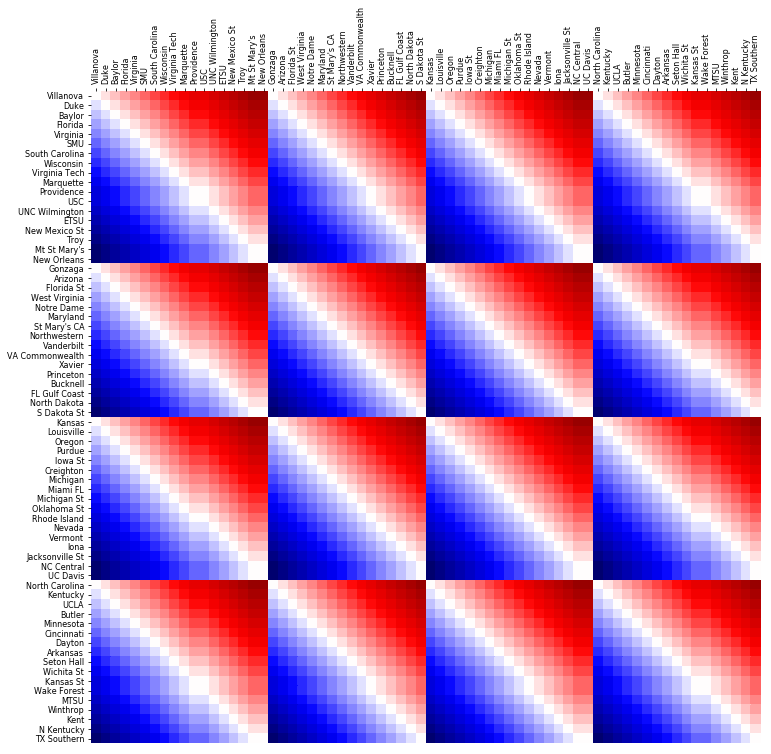

In [19]:
show_heatmap(seed_benchmark_prediction_df(2017))

##### Import Submission File here (current file has random probabilities)

In [20]:
sub = load_sub('SampleSubmissionFormat.csv')
sub.head()

,id,pred
0,2014_1107_1107,0.500000
1,2014_1107_1110,0.957372
2,2014_1107_1112,0.867555
3,2014_1107_1113,0.997846
4,2014_1107_1124,0.978900


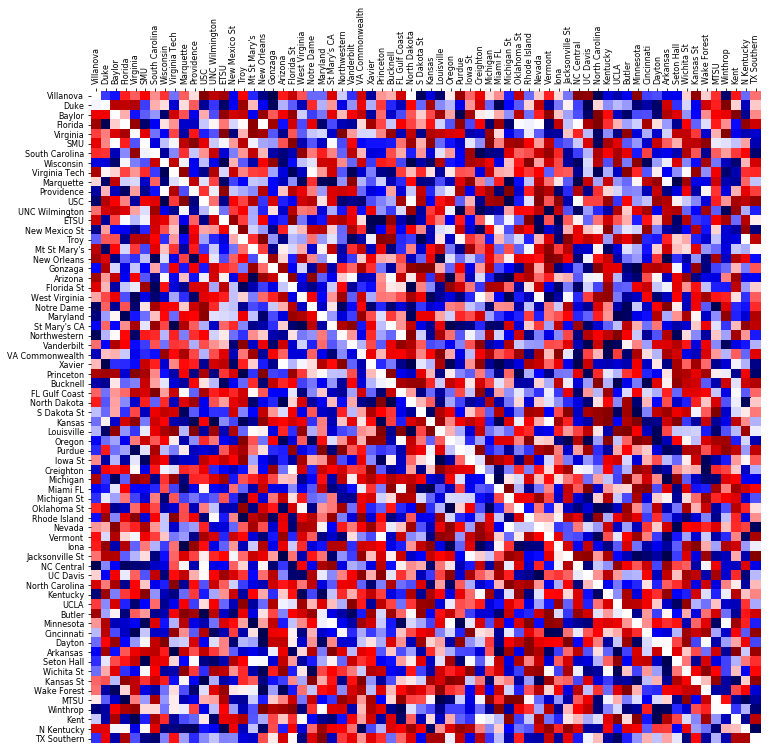

In [21]:
show_heatmap(filter_sub_year(sub, 2017))

##### Remove seed benchmark function

In [22]:
def subtract_seed_benchmark(sub):
    bm = seed_benchmark_prediction_df(get_sub_year(sub)).set_index('id')
    sub = sub.set_index('id')
    sub.pred -= bm.pred
    sub.pred = (sub.pred + 1) / 2  # remap [-1..1] to [0..1]
    return sub.reset_index()

def cmp_seed_benchmark(sub):
    year = get_sub_year(sub)
    sub = sub.set_index('id')
    sub['bm'] = seed_benchmark_prediction_df(year).set_index('id').pred
    sub['diff'] = sub.pred - sub.bm
    return sub.sort_values('diff')

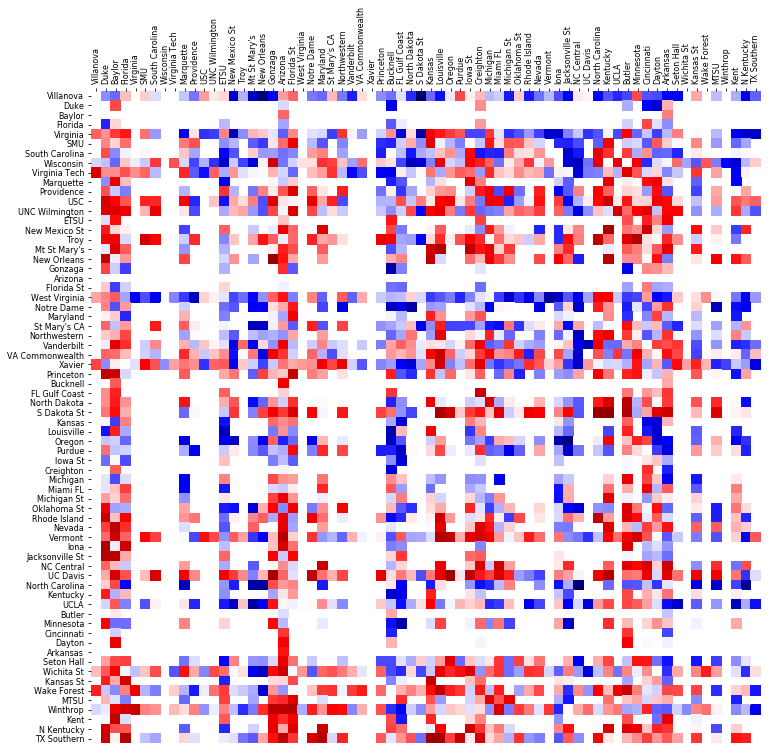

In [23]:
show_heatmap(subtract_seed_benchmark(filter_sub_year(sub, 2017)))